In [1]:
!rm -rf /data/FirstLevelAnalysis_single_run_test_2

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys

sys.path.append('/opt/app')

from fastfmri_toolbox.modelling.design_matrix import DesignMatrix
from fastfmri_toolbox.modelling.first_level_analysis import FirstLevelAnalysis

### Run frequency-base GLM on 4 localizer sessions

In [3]:
%%time

run_one = False
for ix, run_id in enumerate(['01','02','03','04']):
    time_window = (40,219) # Window between these timepoints in seconds
    search_frequencies = [.1]
    bold_path = f'/data/1_attention.7T.oscprep.sub-000/ses-OPCoilCBLowerFrequencyPilot01/func/sub-000_ses-OPCoilCBLowerFrequencyPilot01_task-localizerQ1_acq-mb4_dir-RL_run-{run_id}_space-T1w_desc-preproc_bold.nii.gz'
    mask_path = f'/data/1_attention.7T.oscprep.sub-000/ses-OPCoilCBLowerFrequencyPilot01/func/sub-000_ses-OPCoilCBLowerFrequencyPilot01_task-localizerQ1_acq-mb4_dir-RL_run-{run_id}_space-T1w_desc-boldref_brainmask.nii.gz'
    dm = DesignMatrix(time_window, search_frequencies, bold_path=bold_path)
    design_matrix = dm.build_design_matrix()

    fla = FirstLevelAnalysis(
        derivatives_dir = '/data/FirstLevelAnalysis_single_run_test_2',
        bold_path = bold_path,
        mask_path = mask_path,
        design_matrix = design_matrix,
        time_window = time_window,
        search_frequencies = search_frequencies
    )
    fla.run_frequency_glm(save_windowed_bold = True, save_predicted = True, save_residual = True)
    
    if ix == 0 and run_one:
        break

/usr/local/lib/python3.10/dist-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)
/usr/local/lib/python3.10/dist-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)
/usr/local/lib/python3.10/dist-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)
/usr/local/lib/python3.10/dist-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


CPU times: user 3min 39s, sys: 1min 13s, total: 4min 53s
Wall time: 3min 21s


In [4]:
!tree /data/FirstLevelAnalysis_single_run_test_2

/data/FirstLevelAnalysis_single_run_test_2
└── sub-000
    └── ses-OPCoilCBLowerFrequencyPilot01
        └── task-localizerQ1
            ├── run-01
            │   └── GLM
            │       ├── basis-cosine_f-0.1_effect_size.nii.gz
            │       ├── basis-cosine_f-0.1_effect_variance.nii.gz
            │       ├── basis-cosine_f-0.1_p_value.nii.gz
            │       ├── basis-cosine_f-0.1_stat.nii.gz
            │       ├── basis-cosine_f-0.1_z_score.nii.gz
            │       ├── basis-sine_f-0.1_effect_size.nii.gz
            │       ├── basis-sine_f-0.1_effect_variance.nii.gz
            │       ├── basis-sine_f-0.1_p_value.nii.gz
            │       ├── basis-sine_f-0.1_stat.nii.gz
            │       ├── basis-sine_f-0.1_z_score.nii.gz
            │       ├── frequency-0.1_effect_size.nii.gz
            │       ├── frequency-0.1_effect_variance.nii.gz
            │       ├── frequency-0.1_p_value.nii.gz
            │       ├── frequency-0.1_phaseshift.nii.gz
            

### Investigate phase delays across localizer runs

#### Plot phase shift across all localizer sessions

Phase delay of the frequency basis to the voxel-wise BOLD signal
Histogram counts the number of voxels.


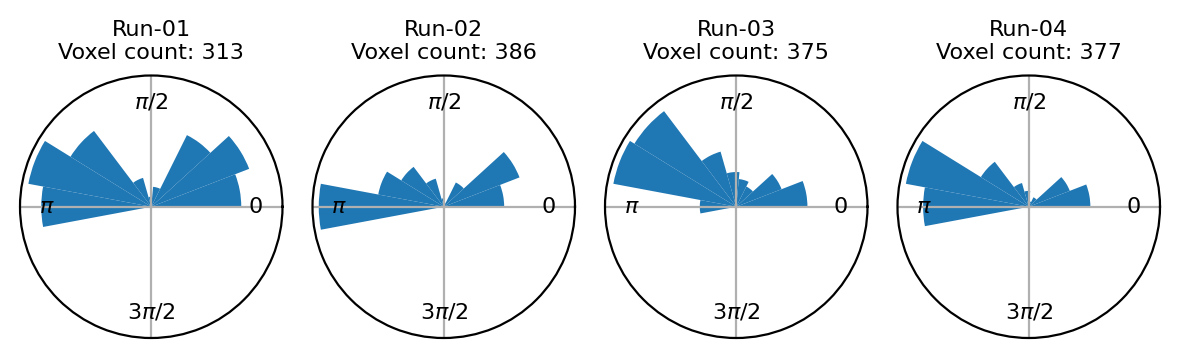

In [5]:
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd

frequency_of_interest = search_frequencies[0]

nrows, ncols = 1, 4
run_ids = ['01','02','03','04']
Z_thr = 3.
fig, ax = plt.subplots(ncols=ncols, nrows=nrows, dpi=200, figsize=(6,6), subplot_kw={'projection':'polar'})

fitted_voxels_df_dict = {}
for ix,(run_id,row_id) in enumerate(zip(run_ids,range(ncols))):
    
    # GLM directory
    glm_dir = f'/data/FirstLevelAnalysis_single_run_test_2/sub-000/ses-OPCoilCBLowerFrequencyPilot01/task-localizerQ1/run-{run_id}/GLM'

    # Get Z-score data of frequency fit
    z_score = nib.load(f"{glm_dir}/frequency-{frequency_of_interest}_z_score.nii.gz").get_fdata()
    # PHI
    phase_angle = nib.load(f"{glm_dir}/frequency-{frequency_of_interest}_phaseshift.nii.gz").get_fdata()

    # Coordinates of all voxels with 3> Z-score
    coords = np.where(z_score > Z_thr)
    _df = pd.DataFrame(
        zip(
            z_score[coords],
            phase_angle[coords],
            *(coords)
        ),
        columns=[
            'z_score',
            'phase_delay_radians',
            'x','y','z'
        ]
    ).sort_values(by='z_score',ascending=False).reset_index(drop=True)
    _df['run_id'] = run_id
    # Convert coordinates to type int
    for dim in ['x','y','z']:
        _df[dim] = _df[dim].astype(int)
        
    if ix == 0:
        fitted_voxels_df = _df
    else:
        fitted_voxels_df = pd.concat((fitted_voxels_df, _df))
    
    # Plot
    phase_delays = fitted_voxels_df[fitted_voxels_df.run_id == run_id]['phase_delay_radians'].values
    ax[row_id,].set_title(f'Run-{run_id}\nVoxel count: {phase_delays.shape[0]}',fontsize=8)
    _ = ax[row_id,].hist(
        phase_delays,
        bins=np.linspace(0,2*np.pi,18)
    )
    ax[row_id,].set_xticks([0, np.pi/2, np.pi, 3/2*np.pi])
    ax[row_id,].set_xticklabels(['0',r'$\pi$/2', r'$\pi$',r'3$\pi$/2'],fontsize=8)
    ax[row_id,].set_yticks([])
    ax[row_id,].tick_params(axis='x', pad=-20)
    
fig.tight_layout()
print(f"Phase delay of the frequency basis to the voxel-wise BOLD signal\nHistogram counts the number of voxels.")

#### Get only consistent voxels across all 4 sessions

In [6]:
fitted_voxels_df[['x','y','z']]
unique_combinations = fitted_voxels_df.groupby(['x', 'y','z']).size().reset_index(name='count')
_x = unique_combinations[unique_combinations['count'] == 4].x
_y = unique_combinations[unique_combinations['count'] == 4].y
_z = unique_combinations[unique_combinations['count'] == 4].z

_data = {}
for run_id in run_ids:
    _data[run_id] = []
    for x,y,z in zip(_x,_y,_z):
        _value = fitted_voxels_df[
            (fitted_voxels_df['x'] == x) &
            (fitted_voxels_df['y'] == y) &
            (fitted_voxels_df['z'] == z) &
            (fitted_voxels_df['run_id'] == run_id)
        ].phase_delay_radians.values[0]
        _data[run_id].append(_value)

#### Plot inter run reproducibility of phase delays

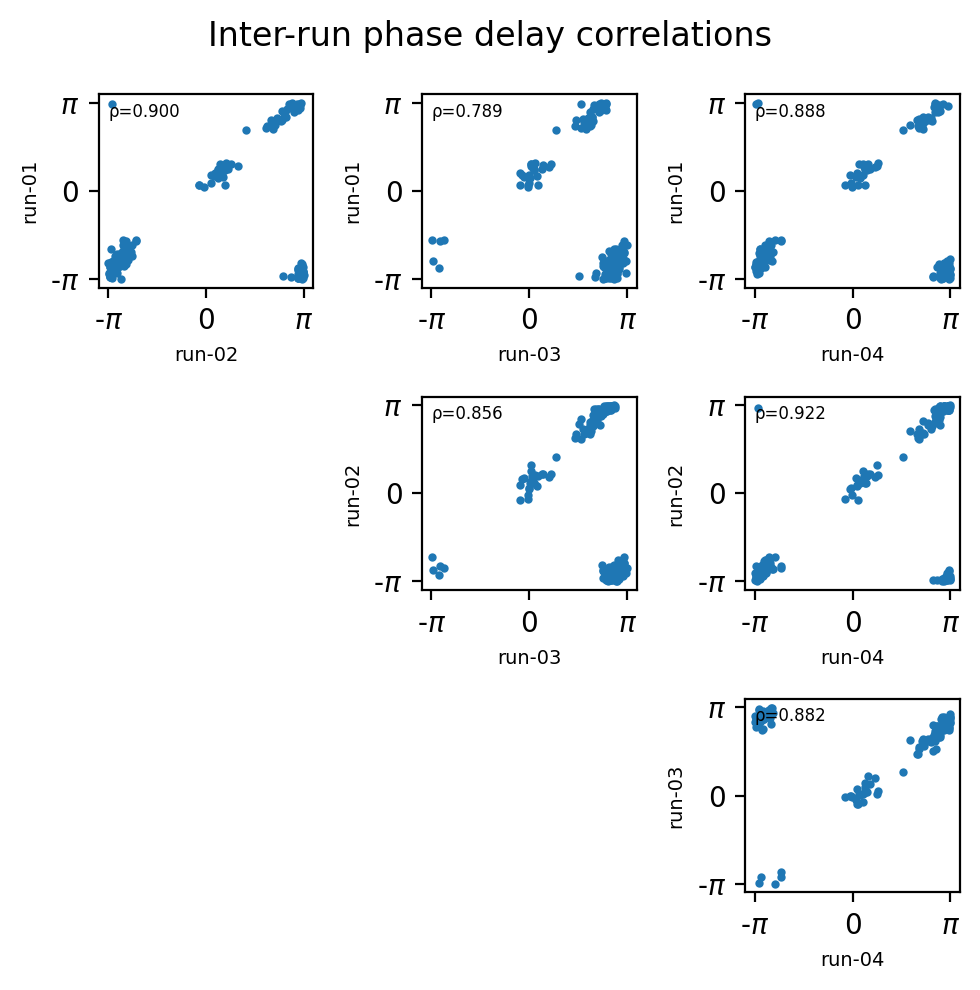

In [7]:
import itertools
from astropy.stats import circcorrcoef

fig, ax = plt.subplots(
    ncols=len(run_ids)-1, 
    nrows=len(run_ids)-1, 
    dpi=200, 
    figsize=(5,5)
)

for run_id_1, run_id_2 in itertools.combinations(run_ids,2):
    circ_r = circcorrcoef(np.array(_data[run_id_1]),np.array(_data[run_id_2]))
    ax[int(run_id_1)-1,int(run_id_2)-2].scatter(
        _data[run_id_2],
        _data[run_id_1],
        s=4
    )
    ax[int(run_id_1)-1,int(run_id_2)-2].set_xlabel(f"run-{run_id_2}",fontsize=7)
    ax[int(run_id_1)-1,int(run_id_2)-2].set_ylabel(f"run-{run_id_1}",fontsize=7)
    ax[int(run_id_1)-1,int(run_id_2)-2].set_xticks([-np.pi, 0, np.pi])
    ax[int(run_id_1)-1,int(run_id_2)-2].set_xticklabels([r'-$\pi$','0',r'$\pi$'],fontsize=10)
    ax[int(run_id_1)-1,int(run_id_2)-2].set_yticks([-np.pi, 0, np.pi])
    ax[int(run_id_1)-1,int(run_id_2)-2].set_yticklabels([r'-$\pi$','0',r'$\pi$'],fontsize=10)
    ax[int(run_id_1)-1,int(run_id_2)-2].text(-np.pi, np.pi-.5, f"\u03C1={circ_r:.3f}",fontsize=6,zorder=3)

for run_id_1, run_id_2 in itertools.product(range(len(run_ids)-1),range(len(run_ids)-1)):
    if ax[run_id_1,run_id_2].get_xlabel() == '':
        ax[run_id_1,run_id_2].remove()
    
fig.suptitle('Inter-run phase delay correlations')
fig.tight_layout()

## Investigate a single voxel from a single run

#### Filter dataframe to only include a single `run_id`

In [8]:
run_id = '01'
TR = .3
row_idx = 0
fitted_voxels_df = fitted_voxels_df[fitted_voxels_df['run_id'] == run_id]

In [9]:
fitted_voxels_df

,z_score,phase_delay_radians,x,y,z,run_id
0,9.016590,-3.133380,30,20,30,01
1,8.973125,2.615820,27,20,28,01
2,8.886397,-3.140022,28,15,28,01
3,8.792798,-2.948488,28,17,28,01
4,8.590784,-2.843470,27,19,29,01
...,...,...,...,...,...,...
308,3.014603,-0.045003,37,17,30,01
309,3.013433,1.257182,35,21,33,01
310,3.007232,0.393832,51,27,42,01
311,3.005424,2.514664,30,22,38,01


#### Grab timeseries

In [10]:
t = dm._get_time_points(TR, time_window) # timepoints

# BOLD response
windowed = nib.load(f"{glm_dir}/windowed_bold.nii.gz").get_fdata()[
    fitted_voxels_df['x'][row_idx],
    fitted_voxels_df['y'][row_idx],
    fitted_voxels_df['z'][row_idx],
    :
]

# Predicted BOLD response
predicted = nib.load(f"{glm_dir}/predicted_bold.nii.gz").get_fdata()[
    fitted_voxels_df['x'][row_idx],
    fitted_voxels_df['y'][row_idx],
    fitted_voxels_df['z'][row_idx],
    :
]

'''
`stim_shift: phase shift to ensure the stimulus intensity begins at a minimum.
`phase_offset`: phase shift required to align stimulus wave to the predicted bold wave.
Note: (+/-) phase shifts the sinusoid to the (left/right)
'''
A_predicted = ( predicted.max() - predicted.min() ) / 2
A_offset = ( predicted.max() + predicted.min() ) / 2
phase_offset = fitted_voxels_df['phase_delay_radians'][row_idx]
stimulus_shift = -np.pi/2 

phase_offset_between_stimuli_and_bold = -1 * ( phase_offset - stimulus_shift ) / ( 2 * np.pi * frequency_of_interest )

# Neural activity
stim_wave = A_predicted* np.sin((2 * np.pi * frequency_of_interest * t) + stimulus_shift) + A_offset

# Phase-shifted neural activity
bold_wave = A_predicted * np.sin((2 * np.pi * frequency_of_interest * t) + phase_offset) + A_offset 

#### Plot single voxel

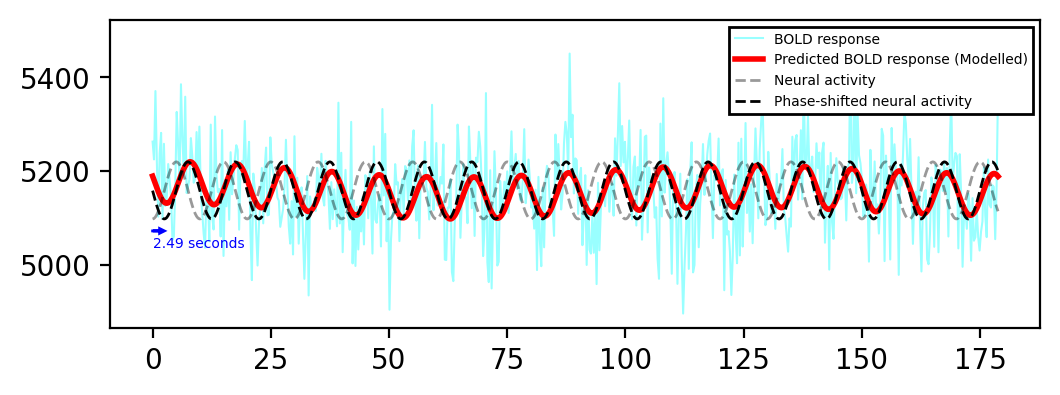

In [11]:
# Figure
fig, ax = plt.subplots(dpi = 200, figsize=(6,2))

# Plot lines
l1, = ax.plot(t,windowed,c='cyan',zorder=1,alpha=.4,lw=.75,
             label='BOLD response')
l2, = ax.plot(t,predicted,c='red',zorder=2,lw=2.,
             label='Predicted BOLD response (Modelled)')
l3, = ax.plot(t,stim_wave,c='k',zorder=3,linestyle='--',lw=1.,alpha=.4,
             label='Neural activity')
l4, = ax.plot(t,bold_wave,c='k',zorder=4,linestyle='--',lw=1.,
             label='Phase-shifted neural activity')

# Legend
ax.legend(
    handles=[l1,l2,l3,l4],
    loc='upper right',
    bbox_to_anchor=(1.,1.),
    fontsize=5,
    frameon=True,
    framealpha=1.,
    edgecolor='k',
    fancybox=False,
)

# Phase delay arrow
head_length, head_width = 1., 10.
_ = ax.arrow(
    0,
    stim_wave.min() - stim_wave.min()*.005,
    (phase_offset_between_stimuli_and_bold)-head_length,
    0,
    head_width=10.,
    head_length=head_length,fc='blue',ec='blue',lw=1.
)
_ = ax.text(
    0,
    stim_wave.min() - stim_wave.min()*.012,
    f'{(phase_offset_between_stimuli_and_bold):.2f} seconds',
    fontsize=5,c='blue'
)

In [12]:
fitted_voxels_df['phase_delay_seconds'] = -1 * ( fitted_voxels_df['phase_delay_radians'] ) / ( 2 * np.pi * frequency_of_interest )
fitted_voxels_df

,z_score,phase_delay_radians,x,y,z,run_id,phase_delay_seconds
0,9.016590,-3.133380,30,20,30,01,4.986929
1,8.973125,2.615820,27,20,28,01,-4.163207
2,8.886397,-3.140022,28,15,28,01,4.997501
3,8.792798,-2.948488,28,17,28,01,4.692664
4,8.590784,-2.843470,27,19,29,01,4.525524
...,...,...,...,...,...,...,...
308,3.014603,-0.045003,37,17,30,01,0.071624
309,3.013433,1.257182,35,21,33,01,-2.000868
310,3.007232,0.393832,51,27,42,01,-0.626803
311,3.005424,2.514664,30,22,38,01,-4.002212


#### Plot hexbin plot of group of voxels

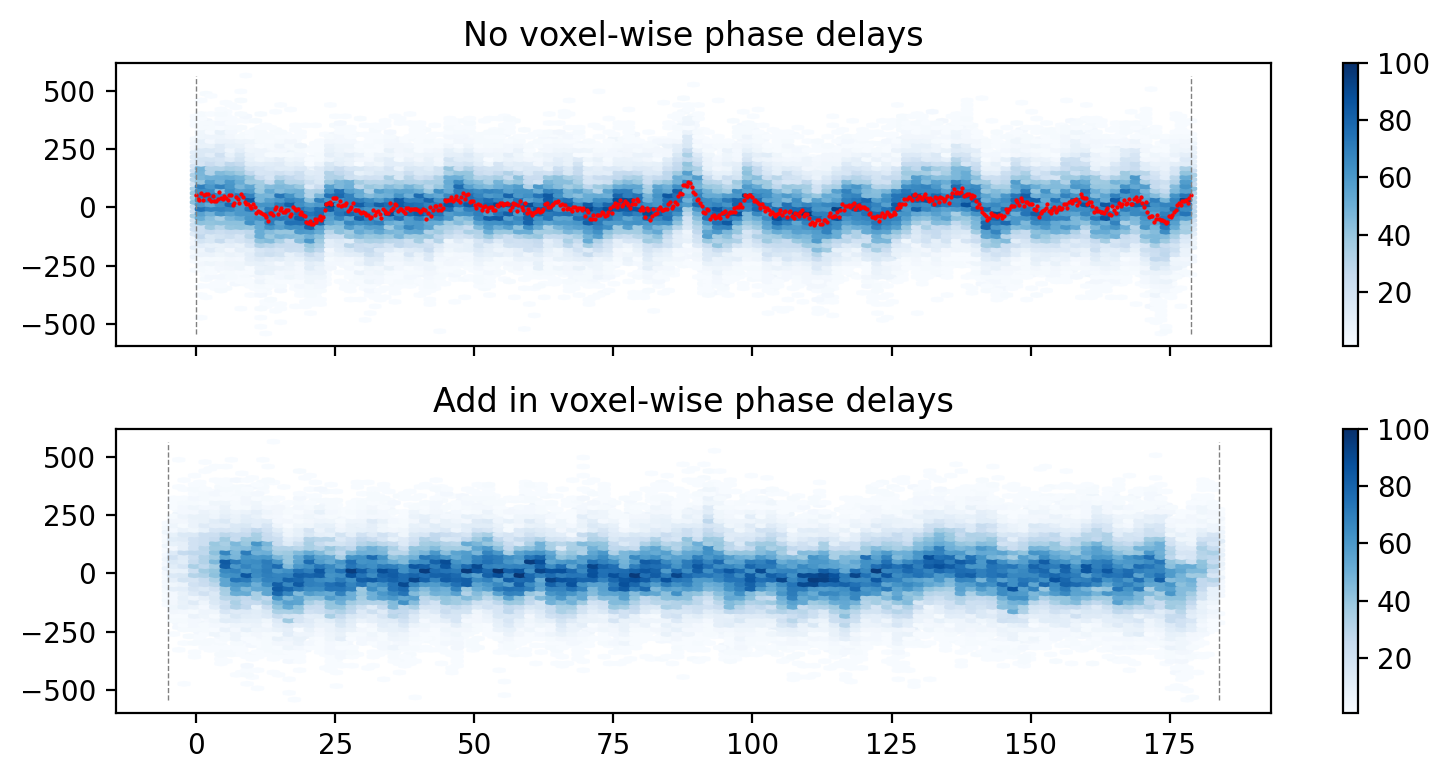

In [14]:
sorted_coords = (
    fitted_voxels_df.x.values,
    fitted_voxels_df.y.values,
    fitted_voxels_df.z.values,
)

fig, (ax1,ax2) = plt.subplots(nrows=2, ncols=1, dpi = 200, figsize=(8,4), sharex=True, sharey=True)

# Timepoints
t = dm._get_time_points(TR, time_window) # timepoints
# Windowed BOLD response
windowed = nib.load(f"{glm_dir}/windowed_bold.nii.gz").get_fdata()[sorted_coords]
# Predicted BOLD response
predicted = nib.load(f"{glm_dir}/predicted_bold.nii.gz").get_fdata()[sorted_coords]


# Raw data of voxels with >3 Z-score
_ax=ax1
_bold=windowed
_bold = ( _bold - _bold.mean(1)[:,np.newaxis] )
vmax = 100
hb = _ax.hexbin(
    t,
    _bold,
    gridsize=100,
    mincnt=1,
    zorder=1,
    cmap='Blues',
    vmax=vmax,
)
_ax.scatter(t,_bold.mean(0),c='red',zorder=2,lw=1.,s=.3)
_ax.set_title('No voxel-wise phase delays')
cb = fig.colorbar(hb)

# Raw data of voxels with >3 Z-score
_ax=ax2
_bold = windowed
_bold = ( _bold - _bold.mean(1)[:,np.newaxis] )

for ix in range(_bold.shape[0]):
    if ix == 0:
        _t_cat = t + fitted_voxels_df['phase_delay_seconds'][ix]
        _bold_cat = _bold[ix,:]
    else:
        _t_cat = np.concatenate((_t_cat, t + fitted_voxels_df['phase_delay_seconds'][ix]))
        _bold_cat = np.concatenate((_bold_cat, _bold[ix,:]))
        
hb = _ax.hexbin(
    _t_cat,
    _bold_cat,
    gridsize=100,
    mincnt=1,
    zorder=1,
    cmap='Blues',
    vmax=vmax,
)
_ax.set_title('Add in voxel-wise phase delays')
cb = fig.colorbar(hb)

ax1.vlines(
    [t.min(), t.max()], 
    ymin = _bold_cat.min(), 
    ymax = _bold_cat.max(),
    color='grey',linestyle='--',lw=.5
)
ax2.vlines(
    [_t_cat.min(), _t_cat.max()], 
    ymin = _bold_cat.min(), 
    ymax = _bold_cat.max(),
    color='grey',linestyle='--',lw=.5
)

fig.tight_layout()